## Outbound email spam detection using Unsupervised ML

**Objective**: To develop an unsupervised machine learning system capable of detecting anomalous outbound emails that may be classified as spam, by identifying patterns and deviations in email features.



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest


In [2]:
#loading the data
df = pd.read_csv('MailCountLog.csv')

In [3]:
df.head(5)

,TimeStamp,EntityId,MachineName,TenantId,UserId,EmailAddress,DisplayName,ClientIP,ClientType,Country,...,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP,FPRate_COMP_vNext,CustomData,Error,__date
0,12/4/2019 13:14,0de16bb3-94aa-4f54-e4f6-08d778bbe2b6,CH2PR04MB6572,edd56ed8-70ca-4351-83cb-4128876592e9,00000483-de56-414f-97d1-b72b620f8c58,PII:H101(MjgJopkn0lXCzsXT6LPZa/aCEGeCi1Sy/SzMJ...,NaN,170.76.157.18,MoMT,US,...,8,8,14,15,0,10000,NaN,NaN,NaN,12/4/2019 0:00
1,12/4/2019 16:25,dd6c22e5-cb71-486a-ee5c-08d778d695c4,BY5PR05MB6916,7d700ef5-a0c9-432a-a2ca-fc29c16f2d00,000004cd-3689-463a-ba8e-36372e58773f,PII:H101(v26ko9EwhcEK5hVGwwR836bLdfmvRE52a651R...,NaN,207.61.138.2,MoMT,CA,...,8,22,30,33,0,10000,NaN,NaN,NaN,12/4/2019 0:00
2,12/4/2019 11:05,86214b1b-2642-4cd7-fad5-08d778a9f148,VI1P193MB0448,de1535eb-16df-4359-90f1-75da64631829,00000f41-9298-4367-b8e4-b75332d537db,PII:H101(ztFxCJGhSYDTiPEcBSxRn2YkkMt2V45YaDKOg...,NaN,41.82.204.130,MoMT,SN,...,2861,4,6,8,0,10000,NaN,NaN,NaN,12/4/2019 0:00
3,12/4/2019 15:55,61eb22b4-4abb-43de-a5f4-08d778d25b73,BN6PR03MB3346,d13a3cbd-e4ce-45e1-91c2-98859a236439,00001702-e253-4739-b720-b55502131ba7,>,NaN,170.138.104.250,MoMT,US,...,0,8,17,12,0,10000,NaN,NaN,NaN,12/4/2019 0:00
4,12/4/2019 13:02,576066b2-f3b5-447b-2936-08d778ba28c9,AM6PR08MB3317,aa3c372d-0013-4bdc-b272-204afc0088b6,00001e01-7559-4f4c-9fc1-7076769d0c77,PII:H101(INn8+kyxBniSNBkiX9cTjsPpTviZ4Iqcv5Dr4...,NaN,89.38.121.125,MoMT,GB,...,1,39,47,47,0,10000,NaN,NaN,NaN,12/4/2019 0:00


##### Dataset Description

The dataset used in this project contains **114 columns** capturing detailed email activity and account metadata, along with multiple identifiers and timestamps. The dataset represents email events for a set of users over a period of time. Key aspects include:

**Identifiers and Metadata**
- **TimeStamp**: The date and time the email event occurred.  
- **EntityId, MachineName, TenantId, UserId**: Unique identifiers for the email, device, tenant, and user.  
- **EmailAddress, DisplayName**: User information.  
- **ClientIP, ClientType, Country**: Source information for the email.  

**Activity Metrics**
- Counts of recipients and messages over various periods:
  - `Last6HrMsgCount`, `Last24HrExtRcptCount`, `TodayExtRcptCount`, `Last192HrIntraSpamMsgCount`, etc.
- Spam-related counts:
  - `TodaySpamRcptCount_Inbound`, `Last1HrSpamRcptCount_Inbound`, `Last30DaySpamRcptCount_Inbound`, etc.
- Running averages:
  - `ThirtyDayRcptAvg`, `ThirtyEntriesRcptAvg`, `FifteenEntriesRcptAvg`.

**Account and Domain Features**
- Account and client history:
  - `AccountAgeInDays`, `PaidSeatCount`, `MinutesFromSenderDomainFirstSeenToNow`, `MinutesFromClientTypeFirstSeenToNow`.
- Risk indicators:
  - `FPRate_COMP`, `BlockedForToday`, `CustomData`, `Error`.



In [4]:
#checking the shape
df.shape

(10000, 114)

In [5]:
#information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 114 entries, TimeStamp to __date
dtypes: float64(6), int64(95), object(13)
memory usage: 8.7+ MB


In [6]:
#statistical summary of the dataset
df.describe()

,DisplayName,TenantAgeInDays,AccountAgeInDays,TrialSeatCount,PaidSeatCount,TodayRcptCount,TodayExtRcptCount,TodaySpamRcptCount,TodaySpamRcptCount_Outbound,TodaySpamRcptCount_Inbound,...,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP,FPRate_COMP_vNext,CustomData,Error
count,0.0,10000.00000,10000.000000,371.000000,8.460000e+03,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,0.0,0.0,0.0
mean,NaN,1609.75810,836.012500,27651.269542,4.983989e+04,151.907600,73.224900,0.310400,0.286900,0.023500,...,7.086020e+07,7.071963e+07,152.773100,227.948500,234.604200,0.000400,8384.621400,NaN,NaN,NaN
std,NaN,843.61535,675.196099,113199.411144,1.835058e+05,694.684053,446.028936,3.967673,3.927204,0.536075,...,2.647248e+08,2.647623e+08,569.986641,945.305662,961.280083,0.019997,3522.889912,NaN,NaN,NaN
min,NaN,0.00000,0.000000,5.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN
25%,NaN,1036.00000,306.000000,25.000000,1.870000e+02,5.000000,0.000000,0.000000,0.000000,0.000000,...,1.640972e+05,2.000000e+00,12.000000,18.000000,17.000000,0.000000,10000.000000,NaN,NaN,NaN
50%,NaN,1735.50000,669.000000,25.000000,2.748500e+03,17.000000,2.000000,0.000000,0.000000,0.000000,...,1.686030e+05,1.100000e+01,27.000000,36.000000,35.000000,0.000000,10000.000000,NaN,NaN,NaN
75%,NaN,2223.00000,1210.000000,75.000000,2.807550e+04,47.000000,11.000000,0.000000,0.000000,0.000000,...,1.689300e+05,8.400000e+01,55.000000,71.000000,71.000000,0.000000,10000.000000,NaN,NaN,NaN
max,NaN,4237.00000,3237.000000,501000.000000,2.393043e+06,10069.000000,7858.000000,126.000000,126.000000,25.000000,...,1.061852e+09,1.061852e+09,5746.000000,10293.000000,10293.000000,1.000000,10000.000000,NaN,NaN,NaN


<b>Data Cleaning</b>

In [7]:
#checking for nulls
df.isna().sum()

TimeStamp                0
EntityId                 0
MachineName              0
TenantId                 0
UserId                   0
                     ...  
FPRate_COMP              0
FPRate_COMP_vNext    10000
CustomData           10000
Error                10000
__date                   0
Length: 114, dtype: int64

In [8]:
#print the percentage of the missing values
summary = pd.DataFrame({'missing_count': df.isna().sum(),
                        'missing_percent': df.isna().mean()*100}).sort_values(by='missing_percent', ascending=False)
summary


,missing_count,missing_percent
Error,10000,100.00
CustomData,10000,100.00
FPRate_COMP_vNext,10000,100.00
DisplayName,10000,100.00
TrialSeatCount,9629,96.29
...,...,...
Last1HrIntraSpamMsgCount,0,0.00
Last1HrSpamMsgCount,0,0.00
Last1HrTotalRcptCount,0,0.00
Last1HrMsgCount,0,0.00


In [ ]:
# Drop columns with upto 90% nulls
drop_cols = summary[(summary['missing_percent'] >= 90)].index.tolist()

# Drop user info
drop_cols += ["EntityId","MachineName","TenantId","UserId","EmailAddress","ClientIP", "__date"]

df_dropped = df.drop(columns=drop_cols, errors="ignore")
df_dropped

,TimeStamp,ClientType,Country,RecipientType,MailboxCreationDate,TenantAgeInDays,AccountAgeInDays,IsTrialTenant,PaidSeatCount,TodayRcptCount,...,MinutesFromClientTypeLastSeenToNow,MinutesFromSenderDomainFirstSeenToNow,MinutesFromSenderDomainLastSeenToNow,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,BlockedForToday,FPRate_COMP
0,12/4/2019 13:14,MoMT,US,UserMailbox,7/2/2012 16:36,2710,2710,False,6.0,14,...,8,321198,8,168515,8,8,14,15,0,10000
1,12/4/2019 16:25,MoMT,CA,UserMailbox,2/23/2017 7:56,2197,1014,False,NaN,9,...,8,305446,8,164356,8,22,30,33,0,10000
2,12/4/2019 11:05,MoMT,SN,UserMailbox,9/26/2018 5:08,969,433,False,152.0,0,...,2861,321110,2861,160045,2861,4,6,8,0,10000
3,12/4/2019 15:55,MoMT,US,UserMailbox,7/19/2019 14:36,2467,137,False,27625.0,6,...,0,1061851195,1061851195,168332,0,8,17,12,0,10000
4,12/4/2019 13:02,MoMT,GB,UserMailbox,4/9/2015 1:51,2016,1700,False,533.0,18,...,1,321458,1,168831,1,39,47,47,0,10000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,12/4/2019 6:39,OWA,IN,UserMailbox,2/2/2017 4:56,2985,1034,False,25163.0,2,...,33,321215,33,164199,33,7,9,9,0,10000
9996,12/4/2019 1:22,MoMT,US,UserMailbox,7/11/2016 12:56,1657,1240,False,19180.0,9,...,5,321293,5,161823,5,19,25,26,0,10000
9997,12/4/2019 17:52,MoMT,US,UserMailbox,7/11/2016 12:56,1657,1240,False,19180.0,23,...,9,322283,9,162813,9,20,26,27,0,10000
9998,12/4/2019 21:21,MoMT,FR,UserMailbox,7/12/2018 12:59,1829,510,False,22300.0,125,...,2,321386,2,2033,2,115,115,93,0,10000


In [10]:
#check for the remaining nulls
col_summary = pd.DataFrame({
    "missing_count": df_dropped.isnull().sum(),
    "missing_percent": df_dropped.isnull().mean() * 100,
}).sort_values(by="missing_percent", ascending=False)

col_summary.head(10)  


,missing_count,missing_percent
PaidSeatCount,1540,15.40
IsTrialTenant,809,8.09
Country,658,6.58
TimeStamp,0,0.00
Last30DaySpamMsgCount,0,0.00
Last60DayIntraSpamMsgCount,0,0.00
Last60DaySpamMsgCount,0,0.00
Last60DayTotalRcptCount,0,0.00
Last60DayMsgCount,0,0.00
Last60DaySpamRcptCount_Inbound,0,0.00


In [11]:
#fill in columns with few nulls
df_dropped = df_dropped.fillna({
    'PaidSeatCount': df_dropped['PaidSeatCount']. median(),
    'IsTrialTenant': df_dropped['IsTrialTenant']. mode()[0],
    'Country': 'Unknown'
})

In [12]:
#convert the date to datetime data type
df_dropped['TimeStamp'] = pd.to_datetime(df_dropped['TimeStamp'], errors='coerce')
df_dropped['MailboxCreationDate'] = pd.to_datetime(df_dropped['MailboxCreationDate'], errors='coerce')

df_dropped['Hours'] = df_dropped['TimeStamp'].dt.hour
df_dropped['Month']= df_dropped['TimeStamp'].dt.month
df_dropped['Day'] = df_dropped['TimeStamp'].dt.day
df_dropped['Year'] = df_dropped['TimeStamp'].dt.year
df_dropped['Minute'] = df_dropped['TimeStamp'].dt.minute

#get number of days the account has been since it's creation
df_dropped['AccountAgeDays'] = (df_dropped['TimeStamp'] - df_dropped['MailboxCreationDate']).dt.days

#drop columns
df_dropped = df_dropped.drop(columns=['TimeStamp','MailboxCreationDate'], axis=1)


In [13]:
#frequency encoding for the country colum
country_freq =  df_dropped['Country'].value_counts()
df_dropped['Country'] = df_dropped['Country'].map(country_freq)

In [ ]:
#encode the recipient type column
df_dropped['RecipientType'] = df_dropped['RecipientType'].map({
    'UserMailbox': 0,
    'MailUniversalDistributionGroup':1
})

In [ ]:
#encode the client type column
encoder = LabelEncoder()
df_dropped['ClientType'] = encoder.fit_transform(df_dropped['ClientType'])

<b>Feature Selection</b>

In [ ]:
#drop columns with low variance
selector = VarianceThreshold(threshold=0.01) 
df_selected = selector.fit_transform(df_dropped)
selected_columns = df_dropped.columns[selector.get_support()]
df_selected = pd.DataFrame(df_selected, columns=selected_columns)
df_selected

,ClientType,Country,TenantAgeInDays,AccountAgeInDays,PaidSeatCount,TodayRcptCount,TodayExtRcptCount,TodaySpamRcptCount,TodaySpamRcptCount_Outbound,TodaySpamRcptCount_Inbound,...,MinutesFromSenderDomainLastSeenToNow,MinutesFromCountryFirstSeenToNow,MinutesFromCountryLastSeenToNow,ThirtyDayRcptAvg,ThirtyEntriesRcptAvg,FifteenEntriesRcptAvg,FPRate_COMP,Hours,Minute,AccountAgeDays
0,1.0,3528.0,2710.0,2710.0,6.0,14.0,11.0,0.0,0.0,0.0,...,8.000000e+00,1.685150e+05,8.000000e+00,8.0,14.0,15.0,10000.0,13.0,14.0,2710.0
1,1.0,343.0,2197.0,1014.0,2748.5,9.0,2.0,0.0,0.0,0.0,...,8.000000e+00,1.643560e+05,8.000000e+00,22.0,30.0,33.0,10000.0,16.0,25.0,1014.0
2,1.0,3.0,969.0,433.0,152.0,0.0,0.0,0.0,0.0,0.0,...,2.861000e+03,1.600450e+05,2.861000e+03,4.0,6.0,8.0,10000.0,11.0,5.0,434.0
3,1.0,3528.0,2467.0,137.0,27625.0,6.0,0.0,0.0,0.0,0.0,...,1.061851e+09,1.683320e+05,0.000000e+00,8.0,17.0,12.0,10000.0,15.0,55.0,138.0
4,1.0,837.0,2016.0,1700.0,533.0,18.0,3.0,0.0,0.0,0.0,...,1.000000e+00,1.688310e+05,1.000000e+00,39.0,47.0,47.0,10000.0,13.0,2.0,1700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,330.0,2985.0,1034.0,25163.0,2.0,0.0,0.0,0.0,0.0,...,3.300000e+01,1.641990e+05,3.300000e+01,7.0,9.0,9.0,10000.0,6.0,39.0,1035.0
9996,1.0,3528.0,1657.0,1240.0,19180.0,9.0,0.0,0.0,0.0,0.0,...,5.000000e+00,1.618230e+05,5.000000e+00,19.0,25.0,26.0,10000.0,1.0,22.0,1240.0
9997,1.0,3528.0,1657.0,1240.0,19180.0,23.0,4.0,0.0,0.0,0.0,...,9.000000e+00,1.628130e+05,9.000000e+00,20.0,26.0,27.0,10000.0,17.0,52.0,1241.0
9998,1.0,320.0,1829.0,510.0,22300.0,125.0,68.0,0.0,0.0,0.0,...,2.000000e+00,2.033000e+03,2.000000e+00,115.0,115.0,93.0,10000.0,21.0,21.0,510.0


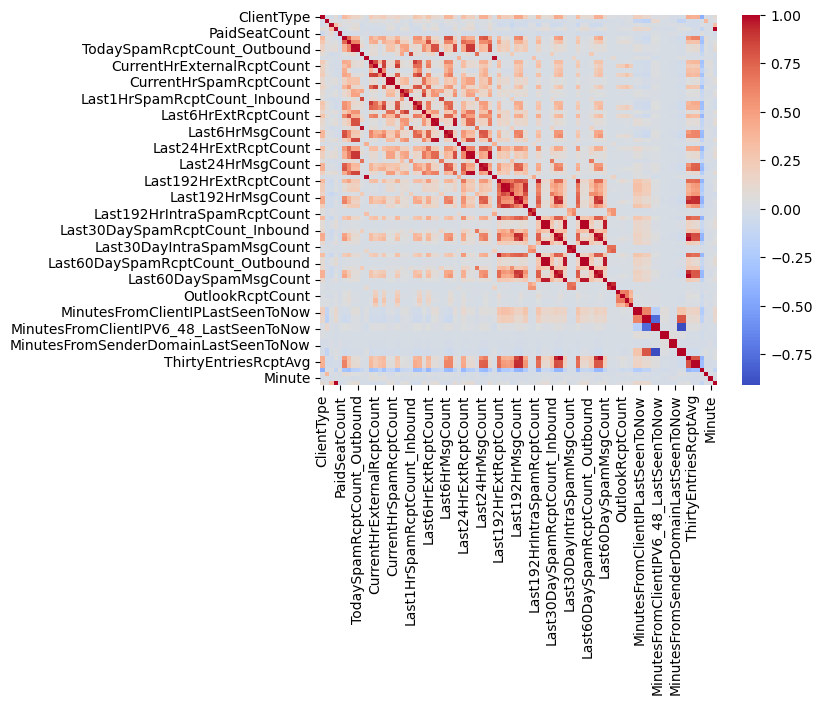

In [ ]:
# show collinearity
corr_matrix = df_selected.corr()


sns.heatmap(corr_matrix,cmap='coolwarm')
plt.show()

In [18]:
#handle multicollinearity
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
df_selected = df_selected.drop(columns=to_drop)

In [19]:
#scale data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_selected)

#dimensionality reduction
pca = PCA(n_components=0.95)
df_pca = pca.fit_transform(df_scaled)

In [20]:
df_pca

array([[-0.69656563,  0.03488561, -0.62963256, ...,  0.77176168,
        -0.0979841 , -0.0056746 ],
       [-0.75976732, -0.17547348, -0.40074905, ..., -0.31820651,
         0.03244915, -1.15436283],
       [-0.90808995, -0.02526627, -0.29095137, ..., -0.0177729 ,
        -0.02070208,  0.06901523],
       ...,
       [-0.71219636, -0.18288571, -0.56790346, ...,  0.41144573,
        -0.13542628, -0.07522614],
       [-0.64532293, -0.09976179, -0.39896034, ..., -0.60274813,
         0.04760382,  0.00348443],
       [-0.80001331,  0.98869977,  2.09778408, ...,  0.45875613,
         0.63833859, -0.00440459]])

<b>Modelling</b>

<i>KMEANS</i>

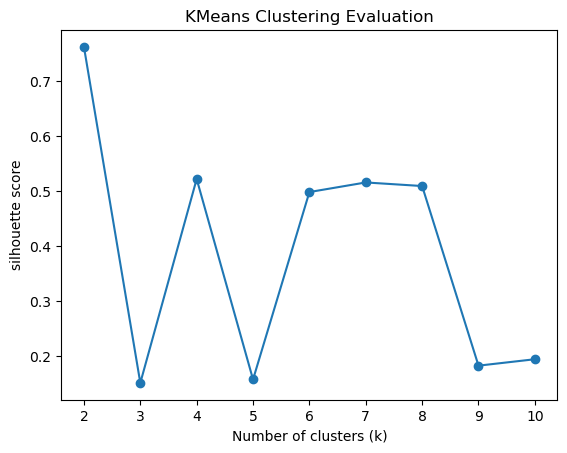

In [21]:
#KMEANS
silhouette_scores = []
K = range(2,11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(df_pca)
    silhouette_scores.append(silhouette_score(df_pca, labels))
#plot
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel("Number of clusters (k)")
plt.ylabel("silhouette score")
plt.title("KMeans Clustering Evaluation")
plt.show()

In [22]:
best_k = 3
kmeans = KMeans(n_clusters=best_k, random_state=42)
results = kmeans.fit_predict(df_pca)

df_clusters = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(df_pca.shape[1])])
df_clusters['Cluster'] = results

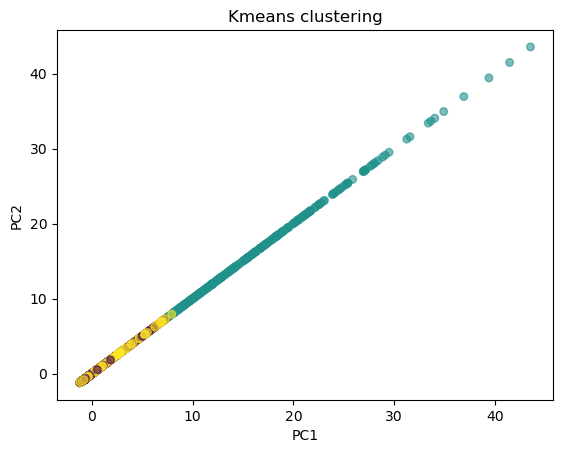

In [23]:
plt.scatter(df_clusters['PC1'],df_clusters['PC1'], c=df_clusters['Cluster'], cmap='viridis',s=30, alpha=0.6)
plt.title("Kmeans clustering")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

From the plot, kmeans forces the data into a pre-defined number of groups, effectively splitting a single, linear-trending group of data into two or three arbitrary clusters. This approach overlooks the presence of outliers.

Therefore Kmeans is less suitable for the data because its purpose is to find clusters, not outliers. It forces all data points into a few groups, even if those groups are not trully distinct from each

In [24]:
df_clusters

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,Cluster
0,-0.696566,0.034886,-0.629633,-0.044826,-0.067617,0.192289,-0.376390,0.003122,0.063954,-1.164740,...,0.051053,0.020304,-0.995431,0.369137,-0.447171,0.196156,0.771762,-0.097984,-0.005675,2
1,-0.759767,-0.175473,-0.400749,0.525040,0.242593,0.024940,-0.758216,-0.141185,0.006080,0.081068,...,-0.817153,-0.053381,0.548597,0.255711,0.310975,0.049396,-0.318207,0.032449,-1.154363,0
2,-0.908090,-0.025266,-0.290951,0.087083,-0.358304,-0.075018,-0.236600,0.065620,-0.051360,0.570781,...,0.051229,0.181994,0.183485,0.397383,0.140488,0.040925,-0.017773,-0.020702,0.069015,0
3,-0.925220,-0.195298,-0.712760,0.086500,-0.591459,-0.105987,-0.351212,0.250212,0.082048,-0.416604,...,0.174613,0.594438,0.356228,-0.800758,-0.149710,-0.178712,0.812346,0.463531,-0.126776,2
4,-0.777310,0.032308,-0.417622,-0.007837,-0.142919,-0.045136,-0.278042,0.011088,0.075480,-0.136096,...,-0.017525,-0.018399,-0.113170,0.706992,0.077338,0.165141,0.214072,-0.071096,0.050089,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.781975,0.051410,-0.365077,-0.073930,-0.166522,0.000148,-0.228189,0.173601,0.009925,0.392713,...,0.155670,-0.233652,0.261444,-0.821159,0.231389,0.059335,-0.105788,0.512493,0.025457,0
9996,-0.792173,-0.055307,-0.498326,-0.008733,-0.395526,-0.057294,-0.383346,0.140911,-0.001542,0.072218,...,0.398627,0.508043,-1.481038,-0.909958,-0.930834,-0.078995,0.947399,-0.038484,-0.008299,0
9997,-0.712196,-0.182886,-0.567903,0.069811,-0.395380,-0.080252,-0.254511,0.049619,0.007049,-0.863505,...,0.050810,0.093278,-0.382219,0.028821,-0.296188,-0.045904,0.411446,-0.135426,-0.075226,2
9998,-0.645323,-0.099762,-0.398960,0.006020,-0.302839,0.138654,-0.188175,-0.127439,-0.086658,-0.306478,...,-0.131552,-0.086550,1.032484,0.552839,0.521213,0.060541,-0.602748,0.047604,0.003484,0


<i>DBSCAN</i>

In [25]:
#DBSCAN (Density-Based Spatial Clustering)
dbscan = DBSCAN(eps=3, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_pca)

df_clusters['DBSCAN'] = dbscan_labels

print(df_clusters['DBSCAN'].value_counts())

DBSCAN
 0     8444
 3      475
 2      417
-1      401
 12      54
 1       43
 7       29
 15      28
 5       19
 14      15
 4       12
 16      11
 9        9
 11       9
 8        7
 17       6
 18       6
 13       5
 10       5
 6        5
Name: count, dtype: int64


<i>Isolation Forest</i>

In [26]:
#isolation forest
iso = IsolationForest(contamination=0.05, random_state=42)
iforest_labels = iso.fit_predict(df_pca)
df_clusters['IForest']=iforest_labels
df_clusters['IForest'].value_counts()

IForest
 1    9500
-1     500
Name: count, dtype: int64

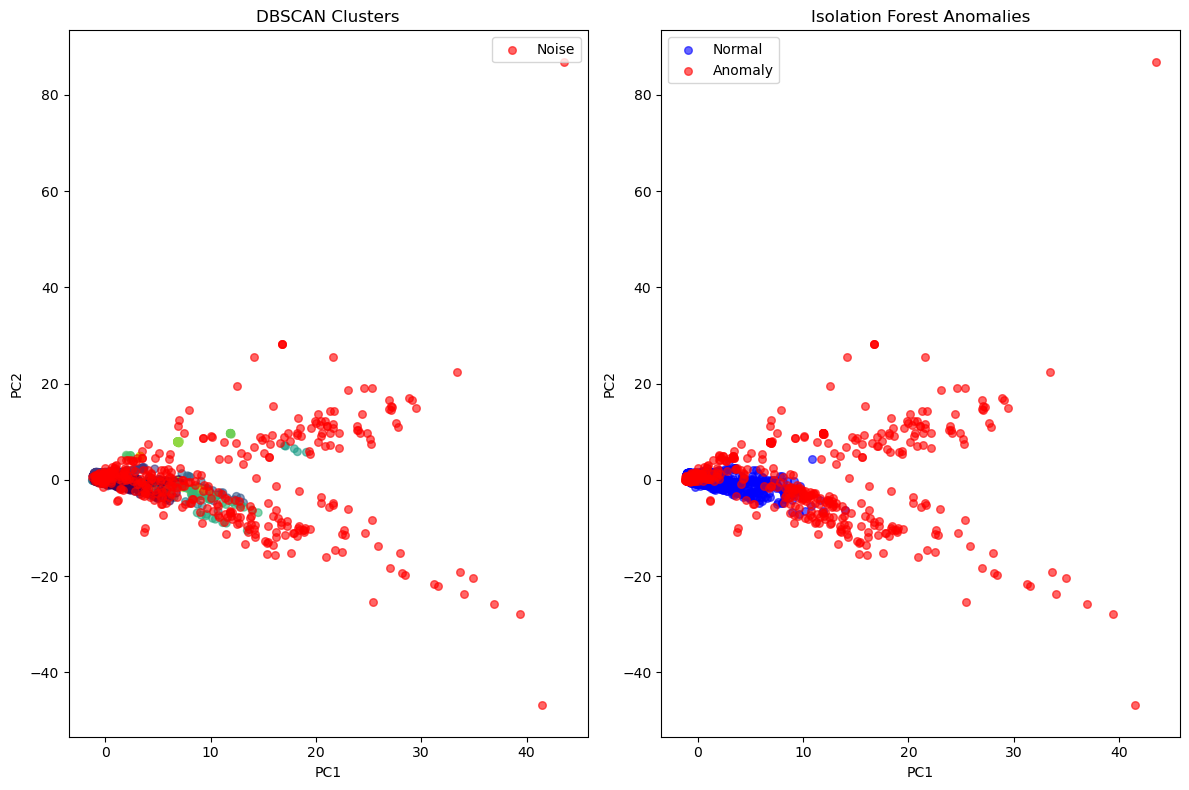

In [27]:
#combined visualization for DBSCAN and isolation forest
pc1 = df_pca[:,0]
pc2 = df_pca[:,1]

plt.figure(figsize=(12,8))

#----DBSCAN Cluster
plt.subplot(1,2,1)
mask = dbscan_labels != -1  # ignore noise
plt.scatter(pc1[mask], pc2[mask], c=dbscan_labels[mask], cmap='viridis', s=30, alpha=0.6)
plt.scatter(pc1[dbscan_labels==-1], pc2[dbscan_labels==-1], c='red', s=30, alpha=0.6, label='Noise')
plt.title("DBSCAN Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

#---isolation forest
plt.subplot(1,2,2)
plt.scatter(pc1[iforest_labels==1], pc2[iforest_labels==1], c='blue', s=30, alpha=0.6, label='Normal')
plt.scatter(pc1[iforest_labels==-1], pc2[iforest_labels==-1], c='red', s=30, alpha=0.6, label='Anomaly')
plt.title("Isolation Forest Anomalies")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

plt.tight_layout()
plt.show()

The DBSCAN and Isolation Forest plots reveal a more accurate and nuanced view of the data's structure. Both algorithms identify a large portion of the data as outliers or anomalies (the scattered red points). A small, concentrated group of points is considered a "cluster" by DBSCAN and "normal" by Isolation Forest.

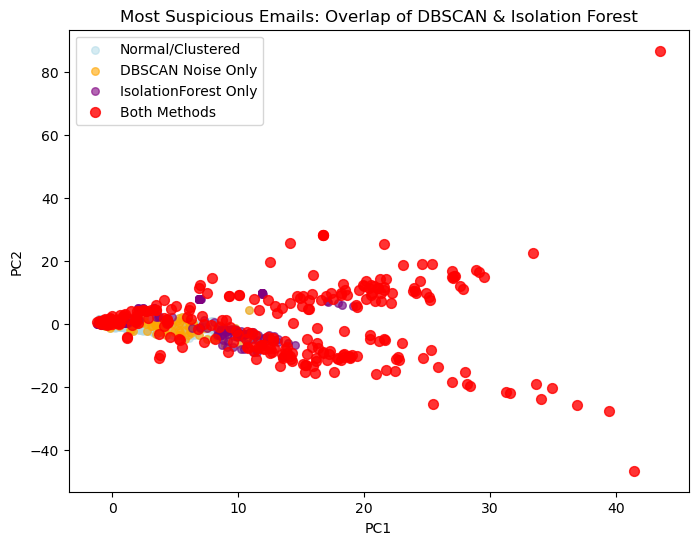

In [ ]:
pc1 = df_pca[:, 0]
pc2 = df_pca[:, 1]

# overlapping anomalies
suspicious_mask = (dbscan_labels == -1) & (iforest_labels == -1)

plt.figure(figsize=(8,6))

# Plot normal points (not anomalies)
normal_mask = ~suspicious_mask
plt.scatter(pc1[normal_mask], pc2[normal_mask], c='lightblue', s=30, alpha=0.5, label='Normal/Clustered')

# Plot points flagged by either method but not both
dbscan_only = (dbscan_labels == -1) & (iforest_labels == 1)
iforest_only = (dbscan_labels != -1) & (iforest_labels == -1)

plt.scatter(pc1[dbscan_only], pc2[dbscan_only], c='orange', s=30, alpha=0.6, label='DBSCAN Noise Only')
plt.scatter(pc1[iforest_only], pc2[iforest_only], c='purple', s=30, alpha=0.6, label='IsolationForest Only')

# overlapping anomalies
plt.scatter(pc1[suspicious_mask], pc2[suspicious_mask], c='red', s=50, alpha=0.8, label='Both Methods')

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Most Suspicious Emails: Overlap of DBSCAN & Isolation Forest")
plt.legend()
plt.show()


The plot demonstrates a strong consensus between DBSCAN and Isolation Forest on identifying outliers. The red points, representing emails flagged as anomalous by both methods, are the most reliable indicators of spam. This high degree of agreement validates my approach and provides a strong, data-backed justification for classifying these emails as spam.

<b>Feature Analysis</b>

In [29]:
n_components = df_pca.shape[1]
df_pca_df = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(n_components)])

df_pca_df['IsolationForest_Label'] = iforest_labels  # 1 = normal, -1 = anomaly
df_pca_df['DBSCAN_Label'] = dbscan_labels            # -1 = noise, 0,1,2,... = clusters

# Compute mean differences for each PCA component
features = df_pca_df.columns[:-2]  # exclude labels
feature_diff_iforest = {}

for feature in features:
    normal = df_pca_df[df_pca_df['IsolationForest_Label']==1][feature]
    anomaly = df_pca_df[df_pca_df['IsolationForest_Label']==-1][feature]
    feature_diff_iforest[feature] = abs(normal.mean() - anomaly.mean())

# Top 5 PCA components
top_pcs = sorted(feature_diff_iforest, key=feature_diff_iforest.get, reverse=True)[:5]
print("Top PCA components contributing to anomalies:", top_pcs)


Top PCA components contributing to anomalies: ['PC1', 'PC3', 'PC15', 'PC6', 'PC2']


In [ ]:
#get the top features contributiing to the PCA features
for top_pc_name in top_pcs:
    pc_index = int(top_pc_name.replace('PC','')) - 1
    loadings = pd.Series(pca.components_[pc_index], index=df_selected.columns)
    top_original_features = loadings.abs().sort_values(ascending=False).head(5)
    print(f"Top original features contributing to {top_pc_name}:")
    print(top_original_features)
    print()


Top original features contributing to PC1:
Last6HrExtRcptCount     0.270350
Last6HrMsgCount         0.254883
TodayExtRcptCount       0.247149
Last1HrMsgCount         0.243453
Last24HrExtRcptCount    0.239849
dtype: float64

Top original features contributing to PC3:
Last192HrSpamRcptCount_Inbound             0.376415
Last192HrSpamRcptCount                     0.322812
MinutesFromClientIPV4_24_FirstSeenToNow    0.286358
Last192HrExtRcptCount                      0.273857
Last30DaySpamRcptCount_Inbound             0.267120
dtype: float64

Top original features contributing to PC15:
MinutesFromSenderDomainFirstSeenToNow    0.616942
MinutesFromClientTypeFirstSeenToNow      0.524078
PaidSeatCount                            0.369038
AccountAgeInDays                         0.196703
Last6HrSpamRcptCount                     0.151766
dtype: float64

Top original features contributing to PC6:
Last192HrIntraSpamMsgCount     0.528171
Last192HrIntraSpamRcptCount    0.512066
Last30DayIntraSpamMsgCou

##### Top Features Driving Anomaly Detection

**PC1 – Recent Outbound Activity**  
- Key features: Last6HrExtRcptCount, Last6HrMsgCount, TodayExtRcptCount  
- Captures unusually high email sending activity over short periods.  

**PC4 – Inbound Spam Exposure**  
- Key features: TodaySpamRcptCount_Inbound, Last1HrSpamRcptCount_Inbound, YahooRcptCount  
- Highlights accounts receiving emails from spam-heavy domains.  

**PC6 – Long-term Internal Spam Behavior**  
- Key features: Last192HrIntraSpamMsgCount, Last192HrIntraSpamRcptCount, Last30DayIntraSpamMsgCount  
- Detects accounts repeatedly sending spam internally.  

**PC15 – Account Age & Sender/Domain History**  
- Key features: MinutesFromSenderDomainFirstSeenToNow, MinutesFromClientTypeFirstSeenToNow, PaidSeatCount  
- Flags new or unusual accounts/domains.  

**PC13 – Historical Spam & Client Metadata**  
- Key features: Last30DaySpamRcptCount_Inbound, MinutesFromClientTypeFirstSeenToNow, PaidSeatCount, FPRate_COMP  
- Combines historical spam patterns and account/client characteristics.
